In [1]:
import os.path
import logging
import re
import numpy as np
from collections import OrderedDict
from scipy.io import loadmat
import torch
import cv2
from torch.nn import functional as F
from utils.network_srmd import SRMD as net 
from utils import utils_deblur
from utils import utils_sisr as sr
from utils import utils_logger
from utils import utils_image as util
from utils import utils_model
import matplotlib.pyplot as plt

In [2]:
def preprocess_srmd(img):
    img_name, ext = os.path.splitext(os.path.basename(img))
    img_L = util.imread_uint(img, n_channels=3)
    img_L = util.uint2single(img_L)
    noise_level_model = 0
    srmd_pca_path = os.path.join('kernels', 'srmd_pca_matlab.mat')
    kernel = utils_deblur.fspecial('gaussian', 15, 0.01)
    P = loadmat(srmd_pca_path)['P']
    degradation_vector = np.dot(P, np.reshape(kernel, (-1), order="F"))
    degradation_vector = np.append(degradation_vector, noise_level_model/255.)
    degradation_vector = torch.from_numpy(degradation_vector).view(1, -1, 1, 1).float()
    img_L = util.single2tensor4(img_L)
    degradation_map = degradation_vector.repeat(1, 1, img_L.size(-2), img_L.size(-1))
    img_L = torch.cat((img_L, degradation_map), dim=1)
    img_L = img_L.to("cpu")
    return img_L

def post_process(output, mod_pad_h, mod_pad_w, mod_scale=4, pre_pad=10):
    scale=1 # hardcoded for model_scale=4
    # remove extra pad
    if mod_scale is not None:
        _, _, h, w = output.size()
        output = output[:, :, 0:h - mod_pad_h * scale, 0:w - mod_pad_w * scale]
    # remove prepad
    if pre_pad != 0:
        _, _, h, w = output.size()
        output = output[:, :, 0:h - pre_pad * scale, 0:w - pre_pad * scale]
    # unsqueze to remove batch
    output = output.squeeze().float().cpu().clamp_(0, 1).numpy()
    # convert to channel last
    output = np.transpose(output, (1, 2, 0))
    output = (output * 255.0).round().astype(np.uint8)
    
    return output

def preprocess(img_path, pre_pad=10, mod_scale=4):
    img = cv2.imread(img_path)
    h_input, w_input = img.shape[0:2]
    # img: numpy
    img = img.astype(np.float32)
    if np.max(img) > 256:  # 16-bit image
        max_range = 65535
        print('\tInput is a 16-bit image')
    else:
        max_range = 255
    img = img / max_range
    if len(img.shape) == 2:  # gray image
        img_mode = 'L'
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:  # RGBA image with alpha channel
        img_mode = 'RGBA'
        alpha = img[:, :, 3]
        img = img[:, :, 0:3]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if alpha_upsampler == 'realesrgan':
            alpha = cv2.cvtColor(alpha, cv2.COLOR_GRAY2RGB)
    else:
        img_mode = 'RGB'
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(np.transpose(img, (2, 0, 1))).float()
    img = img.unsqueeze(0).to("cuda")
    img = F.pad(img, (0, pre_pad, 0, pre_pad), 'reflect')
    
    mod_pad_h, mod_pad_w = 0, 0
    _, _, h, w = img.size()
    if (h % mod_scale != 0):
        mod_pad_h = (mod_scale - h % mod_scale)
    if (w % mod_scale != 0):
        mod_pad_w = (mod_scale - w % mod_scale)
    img = F.pad(img, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
    
    return img, mod_pad_h, mod_pad_w

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [3]:
sf = [int(s) for s in re.findall(r'\d+', "srmd_x4")][0]
model = net(in_nc=19, out_nc=3, nc=128, nb=12, upscale=sf, act_mode='R', upsample_mode='pixelshuffle')
model.load_state_dict(torch.load("C:/Users/ayush/Rizzle/video_super_resolution_speed_optimization/srmd_conversion_tflite/model_zoo/srmd_x4.pth"), strict=False)
model.eval()
for k, v in model.named_parameters(): v.requires_grad = False
model = model.to("cpu")
number_parameters = sum(map(lambda x: x.numel(), model.parameters()))
# logger.info('Params number: {}'.format(number_parameters))

In [4]:
img = "C:/Users/ayush/Rizzle/video_super_resolution_speed_optimization/testing_with_real_esrgan/Real-ESRGAN/inputs/0014.jpg"
preprocessed_img, mod_pad_h, mod_pad_w = preprocess(img)
print(preprocessed_img.shape)
srmd_preprocessed_img = preprocess_srmd(img)
output = model(srmd_preprocessed_img)     
output.shape

torch.Size([1, 3, 192, 192])


torch.Size([1, 3, 716, 716])

In [5]:
output = post_process(output, mod_pad_h, mod_pad_w)

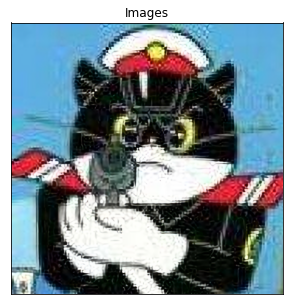

In [6]:
visualize(images=output)

In [7]:
input_names = ["input0"]
output_names = ["output0"]
output_onnx = "srmd_x4.onnx"
torch_out = torch.onnx._export(model, srmd_preprocessed_img, output_onnx, export_params=True, verbose=True,
                               input_names=input_names, output_names=output_names)